In [11]:
#pip install C:\Users\DELL\Desktop\策略代码\TA_Lib-0.4.24-cp38-cp38-win_amd64.whl

Processing c:\users\dell\desktop\策略代码\ta_lib-0.4.24-cp38-cp38-win_amd64.whl
Note: you may need to restart the kernel to use updated packages.


In [12]:
#pip install ta-lib

In [1]:
from WindPy import *
import numpy as np
import pandas as pd
from datetime import *
import talib as ta
import matplotlib.pyplot as plt

import math
from scipy import stats

import datetime
from openpyxl.reader.excel import load_workbook as lw
import pymysql
from pylab import *
from matplotlib.font_manager import FontProperties  
%matplotlib inline
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

Data extraction and processing 数据获取及处理
====

In [6]:
list={'code' : pd.Series(["510310.SH","511010.SH"]),
      'startdate' : pd.Series(["20130401", "20130401"]),
      'enddate': pd.Series(["20220930", "20220930"])}     
asset = pd.DataFrame(list)  

def download_data_from_wind():
    global table
    table = pd.DataFrame(columns = ['time','code','open','high','low','close'])

    list=pd.Series(["510310.SH","511010.SH"])
    asset = pd.DataFrame(list,columns=['code'])
    
    for i in range(len(asset)):
        data = pd.DataFrame()
        indicators = "open,high,low,close"
        startdate = "20130401" #回测起始时间，可自行修改
        enddate = "20220930" #回测结束时间，可自行修改
        vol = w.wsd(asset.code[i], fields = indicators, startdate = startdate, enddate = enddate, option = "unit=1;traderType=1")
        data['time'] = vol.Times
        data['code'] = [vol.Codes[0] for j in range(len(data['time']))]
        data['open'] = vol.Data[0]
        data['high'] = vol.Data[0]
        data['low'] = vol.Data[0]
        data['close'] = vol.Data[0]
        #data['interest'] = [0 for j in range(len(data['time']))] #待改
        #data['return'] = [0] + [((data['price'][j]+data['interest'][j])/(data['price'][j-1]+data['interest'][j-1])-1)for j in range(1,len(data['price']))]
        
        table = pd.concat([table,data],axis = 0,ignore_index = True)

        path = "C:/Users/DELL/Desktop/策略代码/data_eb3.xlsx"
        table.to_excel(path,header=True)

download_data_from_wind()

#codes = "510310.SH,511010.SH" #所需数据的代码。510310为沪深300ETF，511010为五年国债ETF
#indicators = "open,high,low,close" #需要下载的数据指标
#startdate = "20200101" #回测起始时间，可自行修改
#enddate = "20220929" #回测结束时间，可自行修改
#data = w.wsd(codes = codes, fields = indicators, startdate = startdate, enddate = enddate,option = "unit=1;traderType=1") # 导入数据，以pd.DataFrame类型格式存储
#data=w.wss("510310.SH,511010.SH", "close,high,low","tradeDate=20221012;priceAdj=U;cycle=D")
#path ='你数据的存储地址' #将数据保存到你的本地地址（需自行修改）
#data = pd.DataFrame(data,index=[0])
#path = "C:/Users/AXZQ/Desktop/安安新/data_eb.xlsx"
#data.to_excel(path,header=True)

In [7]:
#数据导入
path = "C:/Users/DELL/Desktop/策略代码/data_eb3.xlsx"
data = pd.read_excel(path) #读取数据
data.set_index(data["time"], inplace=True) #设置数据索引为交易日

HS300ETF = pd.DataFrame(data[data["code"] == '510310.SH']["close"].astype(float)) #沪深300ETF专属数据结构。仅保留收盘价格
GZ5yETF = pd.DataFrame(data[data["code"] == '511010.SH']["close"].astype(float)) #国债ETF专属数据结构。仅保留收盘价格

td_dates = HS300ETF.index #记录交易日信息，方便以后进行查找
n = len(td_dates) #记录回溯交易日天数

Module2: calculate return 计算收益率
====

In [8]:
# Module2: 计算收益率
pd.set_option('mode.chained_assignment', None) 

# 创建收益率序列
HS300ETF['RETURN'] = 0 #创建收益率序列
GZ5yETF['RETURN'] = 0 #创建收益率序列
HS300ETF['RETURN'].astype(float)#设定格式为浮点
GZ5yETF['RETURN'].astype(float)#设定格式为浮点

# 计算收益率
HS300ETF["RETURN"][td_dates[1:]] = np.array(HS300ETF["close"][td_dates[1:]]) / np.array(HS300ETF["close"][td_dates[:-1]]) - 1 #计算HS300ETF日收益率

GZ5yETF["RETURN"][td_dates[1:]] = np.array(GZ5yETF["close"][td_dates[1:]]) / np.array(GZ5yETF["close"][td_dates[:-1]]) - 1 #计算GZ5yETF日收益率

# 将收益率序列单独存储至returns
returns = pd.DataFrame({'510310.SH':HS300ETF["RETURN"], '511010.SH':GZ5yETF["RETURN"]},
                       index= td_dates)

print(returns.head())  #打印表头查看

            510310.SH  511010.SH
time                            
2013-04-01   0.000000   0.000000
2013-04-02   0.003109   0.001192
2013-04-03  -0.002066   0.002771
2013-04-08  -0.009317   0.001407
2013-04-09   0.003135  -0.000697


Module 3: statistics-mean, sigma 收益率统计分析模块
====


            从 2019-01-02 00:00:00 到 2022-09-30 00:00:00 ：
        沪深300ETF日均收益率：0.0447%， 日均波动率为：1.3057%
        5年国债ETF日均收益率：0.0115%， 日均波动率为：0.3712%
        


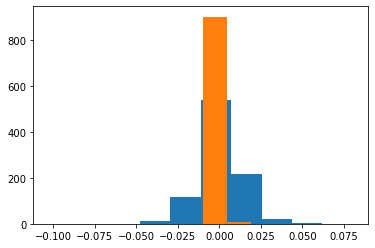

Pearson相关性检验结果：
	相关系数：-0.16030381470886387，p值：1.1391959867971729e-06



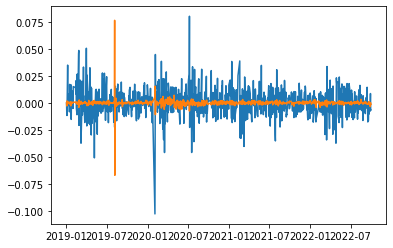

KstestResult(statistic=0.47963867156482026, pvalue=1.9016042894097396e-193)
KstestResult(statistic=0.4949107377479186, pvalue=8.657539619418813e-207)


In [19]:
# Module 3: 收益率统计分析模块
# Step 3.1 计算日均收益率与波动率：
sigma_HS300ETF = np.std(returns['510310.SH'])
sigma_GZ5yETF = np.std(returns['511010.SH'])
r_mean_HS300ETF = np.mean(returns['510310.SH'])
r_mean_GZ5yETF= np.mean(returns['511010.SH'])
print("""
            从 {} 到 {} ：
        沪深300ETF日均收益率：{:.4f}%， 日均波动率为：{:.4f}%
        5年国债ETF日均收益率：{:.4f}%， 日均波动率为：{:.4f}%
        """.format(td_dates[0], td_dates[-1], r_mean_HS300ETF*100,
                   sigma_HS300ETF*100, r_mean_GZ5yETF*100, sigma_GZ5yETF*100))

# Step 3.2 绘制直方图
plt.hist(returns['510310.SH'])
plt.hist(returns['511010.SH'])
plt.show() #画出收益率直方图

# Step 3.3 相关性分析
pearson = stats.pearsonr(returns['510310.SH'], returns['511010.SH'])  # HS300ETF与债券ETF相关性检验
print("Pearson相关性检验结果：\n"
      "\t相关系数：{}，p值：{}\n".format(pearson[0], pearson[1]))
plt.plot(returns['510310.SH'])
plt.plot(returns['511010.SH'])
plt.show()

# Step 3.4 正态性检验
print(stats.kstest(returns['510310.SH'],'norm'))
print(stats.kstest(returns['511010.SH'],'norm'))

从上述结果在可以看出，股票市场相比于债券市场有较高的日收益率，但同时也有较高的波动率。
同时，股票与债券在收益率上有着显著的负相关性，因此可以通过构建二者的组合，降低风险而提升收益率。
基于这一实证结果，构建对应的资产配置策略。

Module 4: benchmarks 纯股与纯债策略
====

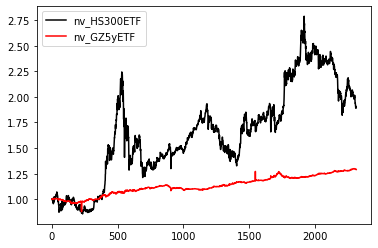

In [9]:
# Module 4: 纯股与纯债策略
nv_HS300ETF = [1]  #记录全仓股票策略净值
nv_GZ5yETF = [1]  #记录全仓债券策略净值

for i in range(n):
    nv_HS300ETF.append( nv_HS300ETF[i] *(1 + returns['510310.SH'][td_dates[i]]))
    nv_GZ5yETF.append( nv_GZ5yETF[i] *(1 + returns['511010.SH'][td_dates[i]]))

t=0
plt.plot(nv_HS300ETF[t:n-t], label = "nv_HS300ETF", color = "black")
plt.plot(nv_GZ5yETF[t:n-t], label = "nv_GZ5yETF", color = "red")
plt.legend()
plt.show()

Module 5: stock+bond
====

stock20%+bond80% 股债二八策略
---

20%的资产投资于股票市场，另外80%的资产投资于债券市场。

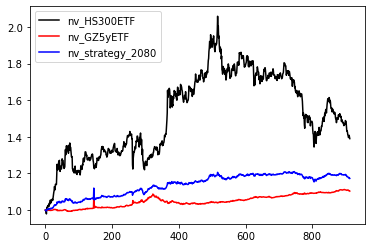

In [21]:
# Module 5: 股债二八策略
nv_strategy_2080 = [1] #记录策略净值
for i in range(n):
      nv_strategy_2080.append( nv_strategy_2080[i] *(1 + 0.2 * returns['510310.SH'][td_dates[i]] + 0.8 * returns['511010.SH'][td_dates[i]]))

plt.plot(nv_HS300ETF, label = "nv_HS300ETF", color = "black")
plt.plot(nv_GZ5yETF, label = "nv_GZ5yETF", color = "red")
plt.plot(nv_strategy_2080, label = "nv_strategy_2080", color = "blue")
plt.legend()
plt.show()

20%+80% assets rotation 动态再平衡股债二八轮动策略
----

      mean_returns    sigmas  sharpe_ratios
纯股        0.000444  0.016254       0.027334
纯债        0.000120  0.004230       0.028365
动量        0.000444  0.016254       0.027334
股债二八      0.000185  0.004632       0.039905
二八轮动      0.000410  0.009397       0.043654
平价轮动      0.000536  0.010257       0.052221


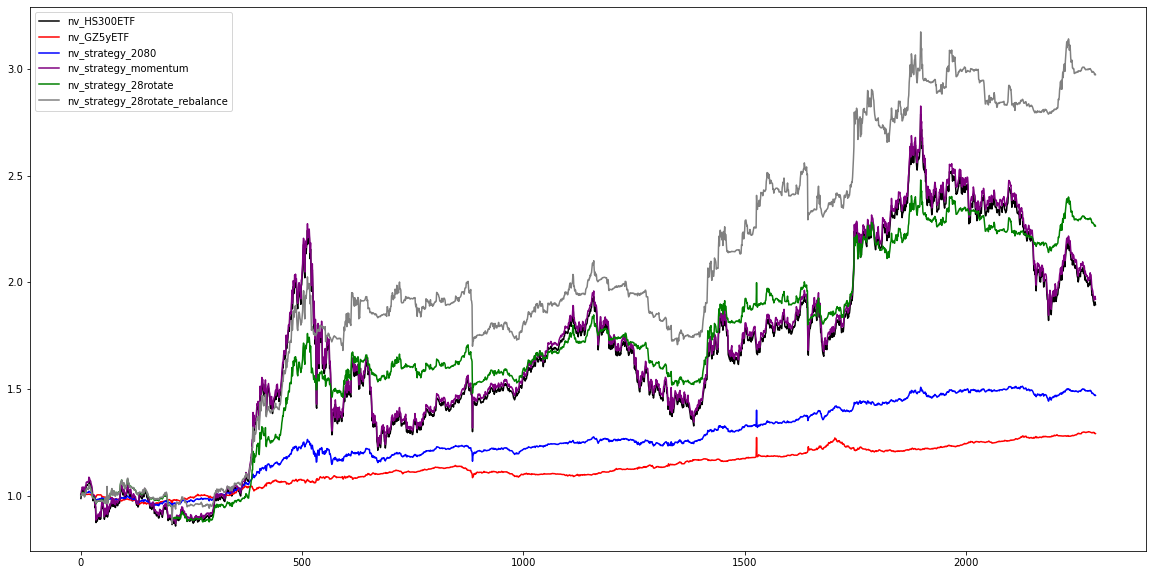

In [10]:
# Module 3: 纯股与纯债策略-------------------------------------
nv_HS300ETF = [1]  #记录全仓股票策略净值
nv_GZ5yETF = [1]  #记录全仓债券策略净值
r_HS300ETF = [] #记录全仓股票策略收益率
r_GZ5yETF = [] #记录全仓债券策略收益率

for i in range(n):
    nv_HS300ETF.append( nv_HS300ETF[i] *(1 + returns['510310.SH'][td_dates[i]]))
    nv_GZ5yETF.append( nv_GZ5yETF[i] *(1 + returns['511010.SH'][td_dates[i]]))
    r_HS300ETF.append(returns['510310.SH'][td_dates[i]])
    r_GZ5yETF.append(returns['511010.SH'][td_dates[i]])
    
# Module 4: 计算窗口期收益率与波动率函数----------------------------------------
# 定义计算移动平均波动率函数：
def Sigma_MA(t, return_series, type):
    """
    t: 回溯窗口长度
    return_series: 收益率序列
    type: 输出序列格式。支持list格式与pd.DataFrame格式
    """
    td_dates = return_series.index
    return_seires = return_series.tolist()#修改代码，list改成df
    n = len(return_series)
    sigma_series = []
    for i in range(t, n):
        sigma_series.append(np.std(return_series[i-t:i]))

    if type == "list":
        return sigma_series
    elif type == "DataFrame":
        return pd.DataFrame({"sigma_series":sigma_series}, index = td_dates[t:n])
    else:
        return "Type Input Error!"

def Momentum_MA(t, return_series, type):
    """
    t: 回溯窗口长度
    return_series: 收益率序列
    type: 输出序列格式。支持list格式与pd.DataFrame格式
    """
    td_dates = return_series.index
    return_seires = pd.DataFrame(return_series)#修改代码，list改成df
    n = len(return_series)
    momentum_series = []
    for i in range(t, n):
        momentum = 1
        for j in range(i-t, i):
            momentum *= 1 + return_series[td_dates[j]]
        momentum_series.append(momentum)

    if type == "list":
        return momentum_series
    elif type == "DataFrame":
        return pd.DataFrame({"momentum_series":momentum_series}, index = td_dates[t:n])
    else:
        return "Type Input Error!"


# Module 5: 计算策略净值与日收益率----------------------------
t = 20  #定义窗口期长度

# Step 1: 计算动量序列与波动率序列：
momentum_seires_HS300ETF = Momentum_MA(t = t, return_series = returns['510310.SH'], type = "DataFrame")['momentum_series']
momentum_seires_GZ5yETF = Momentum_MA(t = t, return_series = returns['511010.SH'], type = "DataFrame")['momentum_series']
sigma_seires_HS300ETF = Sigma_MA(t = t, return_series = returns['510310.SH'], type = "DataFrame")['sigma_series']
sigma_seires_GZ5yETF = Sigma_MA(t = t, return_series = returns['511010.SH'], type = "DataFrame")['sigma_series']


# Sstep 2: 计算各策略收益率与净值序列：
nv_strategy_momentum = [1] # 记录股票动量策略净值
nv_strategy_2080 = [1]  # 记录股债二八策略净值
nv_strategy_28rotate = [1] # 记录股债二八轮动策略净值
nv_strategy_28rotate_rebalance = [1] # 记录动态再平衡股债二八轮动策略净值
r_strategy_momentum = [] # 记录股票动量策略收益率
r_strategy_28rotate = [] # 记录股债二八策略收益率
r_strategy_2080 = [] # 记录股债二八轮动策略收益率
r_strategy_28rotate_rebalance = []  # 记录动态再平衡股债二八轮动策略收益率


for i in range(n):
    nv_strategy_2080.append(nv_strategy_2080[i] * (
            1 + 0.2 * returns['510310.SH'][td_dates[i]] + 0.8 * returns['511010.SH'][td_dates[i]]))
    r_strategy_2080.append(0.2 * returns['510310.SH'][td_dates[i]] + 0.8 * returns['511010.SH'][td_dates[i]])
    # 由于这一策略对样本有损耗，因此需要单独计算
    if td_dates[i] in momentum_seires_HS300ETF.index:

        # 模型1：股债28轮动模型
        # 计算权重
        if momentum_seires_HS300ETF.loc[td_dates[i]] > momentum_seires_GZ5yETF.loc[td_dates[i]]:
            w_bond_daily = 0.2
            w_stock_daily = 1 - w_bond_daily
        else:
            w_bond_daily = 0.8
            w_stock_daily = 1 - w_bond_daily
        # 计算净值
        nv_strategy_28rotate.append(nv_strategy_28rotate[i] * ( 1 + w_stock_daily * returns['510310.SH'][td_dates[i]] + w_bond_daily * returns['511010.SH'][
        td_dates[i]]))
        r_strategy_28rotate.append(w_stock_daily * returns['510310.SH'][td_dates[i]] + w_bond_daily * returns['511010.SH'][td_dates[i]])

        # 模型2：股票纯动量模型
        if momentum_seires_HS300ETF.loc[td_dates[i]] > 0:
            nv_strategy_momentum.append(nv_strategy_momentum[i]* (1 +  returns['510310.SH'][td_dates[i]] ))
            r_strategy_momentum.append( returns['510310.SH'][td_dates[i]] )
        else:
            nv_strategy_momentum.append(nv_strategy_momentum[i] * (1 + returns['511010.SH'][td_dates[i]]))
            r_strategy_momentum.append(returns['511010.SH'][td_dates[i]])

        # 模型3：动态再平衡股债二八轮动组合策略
        # 计算权重
        if momentum_seires_HS300ETF.loc[td_dates[i]] > momentum_seires_GZ5yETF.loc[td_dates[i]]:
            w_stock_daily = sigma_seires_HS300ETF.loc[td_dates[i]] / (
                    sigma_seires_HS300ETF.loc[td_dates[i]] + sigma_seires_GZ5yETF.loc[td_dates[i]])
            w_bond_daily = 1 - w_bond_daily
        else:
            w_bond_daily = sigma_seires_HS300ETF.loc[td_dates[i]] / (
                    sigma_seires_HS300ETF.loc[td_dates[i]] + sigma_seires_GZ5yETF.loc[td_dates[i]])
            w_stock_daily = 1 - w_bond_daily

        # 计算净值
        nv_strategy_28rotate_rebalance.append(nv_strategy_28rotate_rebalance[i] * (1 + w_stock_daily * returns['510310.SH'][td_dates[i]] + w_bond_daily * returns['511010.SH'][td_dates[i]]))
        r_strategy_28rotate_rebalance.append(w_stock_daily * returns['510310.SH'][td_dates[i]] + w_bond_daily * returns['511010.SH'][td_dates[i]])


    else:
        nv_strategy_28rotate.append(nv_strategy_28rotate[i])
        r_strategy_28rotate.append(0)
        nv_strategy_momentum.append(nv_strategy_momentum[i])
        r_strategy_momentum.append(0)
        nv_strategy_28rotate_rebalance.append(nv_strategy_28rotate_rebalance[i])
        r_strategy_28rotate_rebalance.append(0)


# Step 3: 计算各策略日波动率
sigmas = []
sigmas.append(np.std(r_HS300ETF[t:n-t]))
sigmas.append(np.std(r_GZ5yETF[t:n-t]))
sigmas.append(np.std(r_strategy_momentum[t:n-t]))
sigmas.append(np.std(r_strategy_2080[t:n-t]))
sigmas.append(np.std(r_strategy_28rotate[t:n-t]))
sigmas.append(np.std(r_strategy_28rotate_rebalance[t:n-t]))


# Step 4: 计算各策略日收益率
mean_returns = []
mean_returns.append(np.mean(r_HS300ETF[t:n-t]))
mean_returns.append(np.mean(r_GZ5yETF[t:n-t]))
mean_returns.append(np.mean(r_strategy_momentum[t:n-t]))
mean_returns.append(np.mean(r_strategy_2080[t:n-t]))
mean_returns.append(np.mean(r_strategy_28rotate[t:n-t]))
mean_returns.append(np.mean(r_strategy_28rotate_rebalance[t:n-t]))


# Step 5: 计算各策略日夏普比率
sharpe_ratios = []
for i in range(len(sigmas)):
    sharpe_ratios.append(mean_returns[i] / sigmas[i])


# Step 6: 打印结果，并绘制净值走势图
outcome = pd.DataFrame({'mean_returns': mean_returns, 'sigmas': sigmas, 'sharpe_ratios': sharpe_ratios}, index = ['纯股','纯债','动量' ,'股债二八','二八轮动','平价轮动'])
print(outcome)

plt.figure(figsize=(20, 10))
plt.plot(nv_HS300ETF[t:n], label = "nv_HS300ETF", color = "black")
plt.plot(nv_GZ5yETF[t:n], label = "nv_GZ5yETF", color = "red")
plt.plot(nv_strategy_2080[t:n], label = "nv_strategy_2080", color = "blue")
plt.plot(nv_strategy_momentum[t:n], label="nv_strategy_momentum", color="purple")
plt.plot(nv_strategy_28rotate[t:n], label = "nv_strategy_28rotate", color = "green")
plt.plot(nv_strategy_28rotate_rebalance[t:n], label = "nv_strategy_28rotate_rebalance", color = "grey")
plt.legend()
plt.show()

Module 6: Risk parity 股债风险平价策略
====

在 保留“动量效应” 的基础上 加入“风险平价”配置比例，上述公式代替传统股债二八轮动策略中计算权重的方式，即可得到“升级版”模型——动态再平衡股债二八轮动策略。

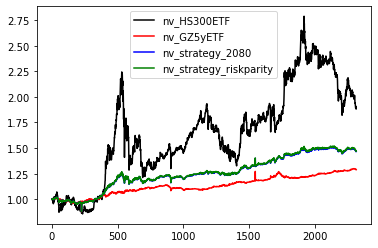

In [11]:
# Module 6: 股债风险平价策略
# 计算长期波动率 
sigma_HS300ETF = np.std(returns['510310.SH'])
sigma_GZ5yETF = np.std(returns['511010.SH'])

# 计算权重
w_bond = sigma_HS300ETF/(sigma_HS300ETF + sigma_GZ5yETF)
w_stock = sigma_GZ5yETF/(sigma_HS300ETF + sigma_GZ5yETF)

# 计算策略净值
nv_strategy_riskparity = [1]
for i in range(n):
    nv_strategy_riskparity.append(nv_strategy_riskparity[i] * (
            1 + w_stock * returns['510310.SH'][td_dates[i]] + w_bond * returns['511010.SH'][td_dates[i]]))

# 绘制策略净值图
plt.plot(nv_HS300ETF, label = "nv_HS300ETF", color = "black")
plt.plot(nv_GZ5yETF, label = "nv_GZ5yETF", color = "red")
plt.plot(nv_strategy_2080, label = "nv_strategy_2080", color = "blue")
plt.plot(nv_strategy_riskparity, label = "nv_strategy_riskparity", color ="green" )
plt.legend()
plt.show()

Module 7: Risk parity dynamics 动态再平衡的股债风险平价策略
====

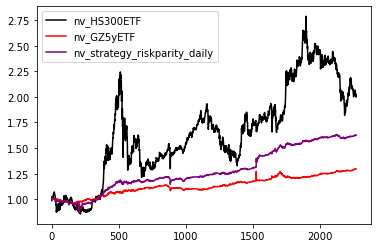

In [12]:
# Module 7: 动态再平衡的股债风险平价策略
# 定义计算移动平均波动率函数：
def Sigma_MA(t, return_series, type):
    """
    t: 回溯窗口长度
    return_series: 收益率序列
    type: 输出序列格式。支持list格式与pd.DataFrame格式
    """
    td_dates = return_series.index
    return_seires =return_series.tolist() #修改代码，list改成df
    n = len(return_series)
    sigma_series = []
    for i in range(t, n):
        sigma_series.append(np.std(return_series[i-t:i]))

    if type == "list":
        return sigma_series
    elif type == "DataFrame":
        return pd.DataFrame({"sigma_series":sigma_series}, index = td_dates[t:n])
    else:
        return "Type Input Error!"

# 设置回溯窗口长度
t = 20
sigma_seires_HS300ETF = Sigma_MA(t = t, return_series = returns['510310.SH'], type = "DataFrame")['sigma_series']
sigma_seires_GZ5yETF = Sigma_MA(t = t, return_series = returns['511010.SH'], type = "DataFrame")['sigma_series']

nv_strategy_riskparity_daily = [1]
for i in range(n):
    # 由于这一策略对样本有损耗，因此需要单独计算
    if td_dates[i] in sigma_seires_HS300ETF.index:
        # 计算权重
        w_bond_daily = sigma_seires_HS300ETF.loc[td_dates[i]] / (
            sigma_seires_HS300ETF.loc[td_dates[i]] + sigma_seires_GZ5yETF.loc[td_dates[i]])
        w_stock_daily = 1 - w_bond_daily
        # 计算净值

        nv_strategy_riskparity_daily.append(nv_strategy_riskparity_daily[i] * (
            1 + w_stock_daily * returns['510310.SH'][td_dates[i]] + w_bond_daily * returns['511010.SH'][
        td_dates[i]]))
    else:
        nv_strategy_riskparity_daily.append(nv_strategy_riskparity_daily[i])

# 绘制净值图
plt.plot(nv_HS300ETF[t:n-t], label = "nv_HS300ETF", color = "black")
plt.plot(nv_GZ5yETF[t:n-t], label = "nv_GZ5yETF", color = "red")
plt.plot(nv_strategy_riskparity_daily[t:n-t], label = "nv_strategy_riskparity_daily", color ="purple" )
plt.legend()
plt.show()

Module 8: Results summary and visualization 策略比较
====

      mean_returns    sigmas  sharpe_ratios
纯股        0.000444  0.016254       0.027334
纯债        0.000120  0.004230       0.028365
股债二八      0.000185  0.004632       0.039905
风险平价      0.000187  0.004679       0.039900
再平衡       0.000220  0.003606       0.060952


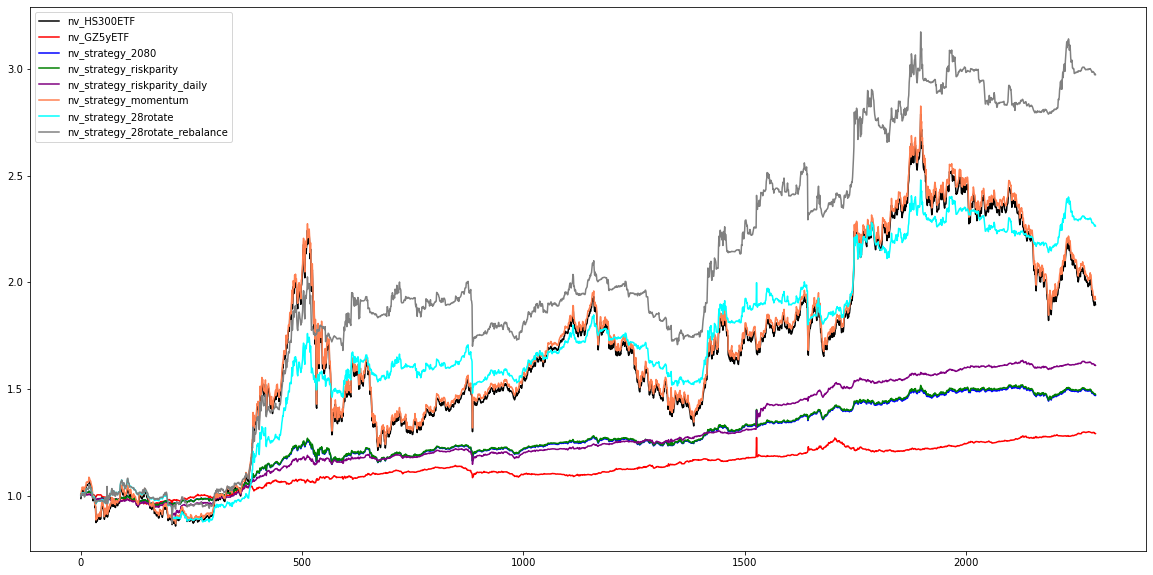

In [13]:
# Module 8: 策略比较
# 1. 各策略日收益初始化
r_strategy_2080 = []
r_strategy_riskparity = []
r_strategy_riskparity_daily = []
r_HS300ETF = []
r_GZ5yETF = []

# 2.计算各策略日收益率
for i in range(n):
    r_HS300ETF.append(returns['510310.SH'][td_dates[i]])
    r_GZ5yETF.append(returns['511010.SH'][td_dates[i]])
    r_strategy_2080.append(0.2 * returns['510310.SH'][td_dates[i]] + 0.8 * returns['511010.SH'][td_dates[i]])
    r_strategy_riskparity.append(w_stock * returns['510310.SH'][td_dates[i]] + w_bond * returns['511010.SH'][td_dates[i]])
    if td_dates[i] in sigma_seires_HS300ETF.index:
        w_bond_daily = sigma_seires_HS300ETF.loc[td_dates[i]] / (
                    sigma_seires_HS300ETF.loc[td_dates[i]] + sigma_seires_GZ5yETF.loc[td_dates[i]])
        w_stock_daily = 1 - w_bond_daily
        r_strategy_riskparity_daily.append(w_stock_daily * returns['510310.SH'][td_dates[i]] + w_bond_daily * returns['511010.SH'][
                td_dates[i]])
    else:
        r_strategy_riskparity_daily.append(0)

# Step 3: 计算各策略日波动率
sigmas = []
sigmas.append(np.std(r_HS300ETF[t:n-t]))
sigmas.append(np.std(r_GZ5yETF[t:n-t]))
sigmas.append(np.std(r_strategy_2080[t:n-t]))
sigmas.append(np.std(r_strategy_riskparity[t:n-t]))
sigmas.append(np.std(r_strategy_riskparity_daily[t:n-t]))

# Step 4: 计算各策略日收益率
mean_returns = []
mean_returns.append(np.mean(r_HS300ETF[t:n-t]))
mean_returns.append(np.mean(r_GZ5yETF[t:n-t]))
mean_returns.append(np.mean(r_strategy_2080[t:n-t]))
mean_returns.append(np.mean(r_strategy_riskparity[t:n-t]))
mean_returns.append(np.mean(r_strategy_riskparity_daily[t:n-t]))

# Step 5: 计算各策略日夏普比率
sharpe_ratios = []
for i in range(len(sigmas)):
    sharpe_ratios.append(mean_returns[i] / sigmas[i])

# Step 6: 打印结果，并绘制净值走势图
outcome = pd.DataFrame({'mean_returns': mean_returns, 'sigmas': sigmas, 'sharpe_ratios': sharpe_ratios}, index = ['纯股','纯债','股债二八','风险平价','再平衡'])
print(outcome)

plt.figure(figsize=(20, 10))
plt.plot(nv_HS300ETF[t:n], label = "nv_HS300ETF", color = "black")
plt.plot(nv_GZ5yETF[t:n], label = "nv_GZ5yETF", color = "red")
plt.plot(nv_strategy_2080[t:n], label = "nv_strategy_2080", color = "blue")
plt.plot(nv_strategy_riskparity[t:n], label = "nv_strategy_riskparity", color ="green" )
plt.plot(nv_strategy_riskparity_daily[t:n], label = "nv_strategy_riskparity_daily", color ="purple" )
plt.plot(nv_strategy_momentum[t:n], label="nv_strategy_momentum", color="coral")
plt.plot(nv_strategy_28rotate[t:n], label = "nv_strategy_28rotate", color = "cyan")
plt.plot(nv_strategy_28rotate_rebalance[t:n], label = "nv_strategy_28rotate_rebalance", color = "grey")
plt.legend()
plt.show()